# Self-supervised learning with rotation-prediction task
In this notebook we are going to explore the rotation-prediction self-supervised task on the dataset Fashion-MNIST

**Importing dependencies**

In [1]:
from matplotlib import pyplot as plt 
import keras
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

**Parameter definition**

In [2]:
BATCH_SIZE = 128
EPOCHS = 100

**Loading the dataset Fashion-MNIST dataset**

In [3]:
# Load Fashion-MNIST dataset 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

print('Training set shape: ', x_train.shape)
print('Testing set shape: ', x_test.shape)

Training set shape:  (60000, 28, 28)
Testing set shape:  (10000, 28, 28)


**Before training our model, let's define a generator that will give us rotated images and their labels**

In [4]:
# This generator is used to get the training batches
def generator(train_data, batch_size):
    
    # Loop forever so the generator never terminates
    while True: 
        num_samples = len(train_data)
        
        # Get index to start each batch: [0, batch_size, 2*batch_size, 3*batch_size, ...] 
        for offset in range(0, num_samples, batch_size):
   
            # Get the samples we will use in this batch
            batch_samples = train_data[offset:offset+batch_size] # [0:128] / [128:256] / ...
 
            # Initialise X_batch and y_batch arrays for this batch
            X_batch = []
            y_batch = []

            # For each example
            for batch_sample in batch_samples:
                
                # Rotation to apply
                # 0 = 0º, 1 = 90º, 2 = 180º, 3 = 270º 
                
                # We are going to generate the four rotations for the same image 
                # Instead of each time randomly sampling a single rotation transformation

                # Add example to arrays
                X_batch.append(batch_sample)
                y_batch.append(0)

                X_batch.append(np.rot90(batch_sample, 1))
                y_batch.append(1)

                X_batch.append(np.rot90(batch_sample, 2))
                y_batch.append(2)

                X_batch.append(np.rot90(batch_sample, 3))
                y_batch.append(3)

                # so the actual batch size will be BATCH_SIZE*4, like the original paper
                # because we are generating the four rotations for the same image in this loop

            # Make sure they're numpy arrays 
            X_batch = np.array(X_batch)
            y_batch = np.array(tf.keras.utils.to_categorical(y_batch))

            # The generator will give us the next training batch            
            yield X_batch, y_batch

train_generator = generator(x_train, batch_size=BATCH_SIZE)

**Let's visualize some rotated images**

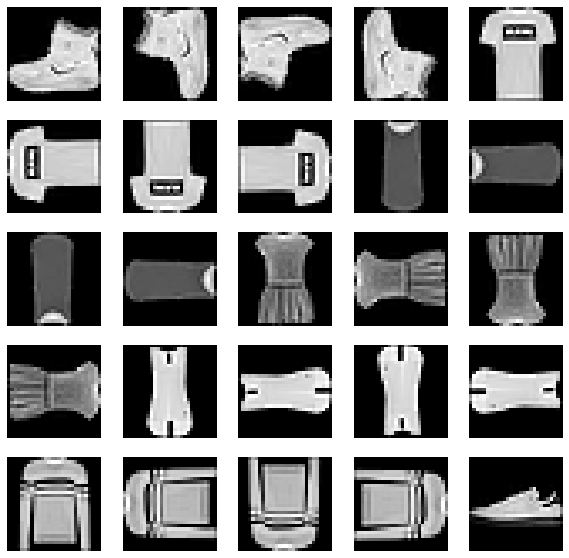

In [5]:
# Visualize a few augmented images.
image_sample = next(iter(train_generator))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_sample[0][n], cmap='gray')
    plt.axis("off")
plt.show()

**Building our 
model**

In [6]:
x_input = tf.keras.Input([28, 28, 1])
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x_input)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(16)(x) # We will use this 16-D as feature representation
x = tf.keras.layers.Dense(4, activation='softmax')(x) # The rotation task can be viewd as 4-class classification problem

model = tf.keras.Model(x_input, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68    

**Compile and train our model**



Epoch 1/100
1000/1000 [==============================] - 32s 30ms/step - loss: 0.6687
Epoch 2/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.4005
Epoch 3/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.3164
Epoch 4/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.2585
Epoch 5/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.2186
Epoch 6/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1911
Epoch 7/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1707
Epoch 8/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1590
Epoch 9/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1474
Epoch 10/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1372
Epoch 11/100
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1305
Epoch 12/100
1000/1000 [============================

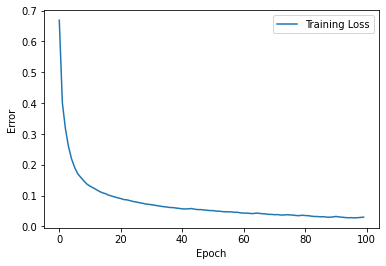

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=1000,
                    verbose=1)

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Training Loss'], loc='upper right')

**Let's use tSNE to visualize the features that we learned**

We're going to use 2.000 images from the test set for the visualization 

In [8]:
x_test_tsne, _, y_test_tsne, _ = train_test_split(x_test, y_test, train_size=2000, random_state=42, stratify=y_test)  

# Here we will extract the 16-D layer as the feature representation
features_model = tf.keras.Model(model.input, model.layers[-2].output)
features = features_model.predict(x_test_tsne)
features = np.array(features)
features.shape
# Now we have the 16-D feature representation for the 2.000 images

(2000, 16)

Code for the tSNE plot:

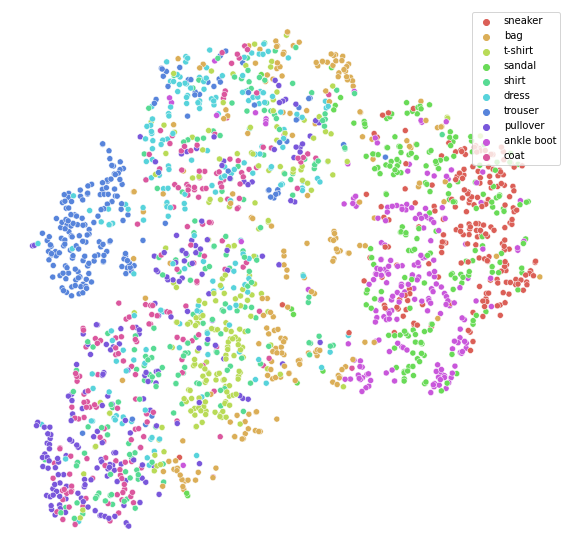

In [14]:
feat_cols = [ 'pixel'+str(i) for i in range(features.shape[1]) ]
df = pd.DataFrame(features,columns=feat_cols)
n_classes = 10
transdict = {0:'t-shirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'ankle boot'}
y_train_label = np.array([transdict[x] for x in y_test_tsne])
df['y'] = y_train_label
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(features)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,10))
sns_tsne_plot = sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="y",
            palette=sns.color_palette("hls", n_classes),
            data=df.loc[rndperm,:],
            legend='full',
            alpha=1.0
            
)
plt.axis('off')
plt.legend(fontsize='medium', loc='upper right')
plt.show()

Without explicity training to recognize classes, we can see that we learned 'good' features 

**SVM classification**

We will use
- features extracted from 5.000 images of the test set to train a linear SVM
- features extracted from 5.000 images of the test set to test the linear SVM

In [10]:
from sklearn import svm
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(x_test, y_test, train_size=int(len(x_test)/2), random_state=42, stratify=y_test)  

clf = svm.SVC(C=1, kernel="linear", max_iter=-1, random_state=42)
clf.fit(features_model.predict(x_train_svm), y_train_svm)
score = clf.score(features_model.predict(x_test_svm), y_test_svm)
print(score)

0.7004


Let's generate the tSNE visualization of the features but *without* training the model

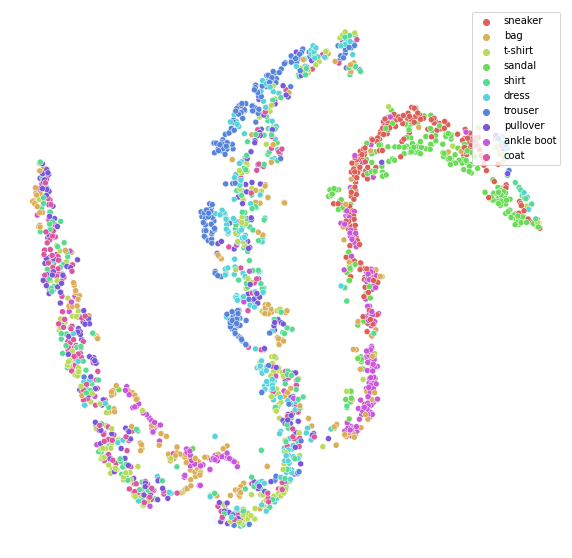

In [17]:
x_input_2 = tf.keras.Input([28, 28, 1])
x_2 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x_input_2)
x_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_2)
x_2 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x_2)
x_2 = tf.keras.layers.GlobalAveragePooling2D()(x_2)
x_2 = tf.keras.layers.Dense(16)(x_2) # We will use this 16-D as feature representation
x_2 = tf.keras.layers.Dense(4, activation='softmax')(x_2) # The rotation task can be viewd as 4-class classification problem

random_model = tf.keras.Model(x_input_2, x_2)
random_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

# Here we will extract the 16-D layer as the feature representation
random_model = tf.keras.Model(random_model.input, random_model.layers[-2].output)
random_features = random_model.predict(x_test_tsne)
random_features = np.array(random_features)
random_features.shape
# Now we have the 16-D feature representation for the 600 images

feat_cols = [ 'pixel'+str(i) for i in range(random_features.shape[1]) ]
df = pd.DataFrame(random_features,columns=feat_cols)
n_classes = 10
transdict = {0:'t-shirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'ankle boot'}
y_train_label = np.array([transdict[x] for x in y_test_tsne])
df['y'] = y_train_label
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(random_features)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,10))
sns_tsne_plot = sns.scatterplot(
            x="tsne-2d-one", y="tsne-2d-two",
            hue="y",
            palette=sns.color_palette("hls", n_classes),
            data=df.loc[rndperm,:],
            legend='full',
            alpha=1.0
            
)
plt.axis('off')
plt.legend(fontsize='medium', loc='upper right')
plt.show()

SVM classification score of the model without training:


In [12]:
clf2 = svm.SVC(C=1, kernel="linear", max_iter=-1, random_state=42)
clf2.fit(random_model.predict(x_train_svm), y_train_svm)
score_2 = clf2.score(random_model.predict(x_test_svm), y_test_svm)
print(score_2)

0.2658
